In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

1. 상위 7개의 state만 사용한다

    * 전체 state는 19개이고 지중 88%이 7개의 state만 사용된다.

<br>

2. Sampling rate

    * 각 파일의 sampling rate의 종류는 OOO가 있고 각각 n개 존재한다.(비율로 표시)

    * Sampling rate 변환 전/후 스펙트럼 이미지 비교

    * (미정) : nan 값과 1600 sampling rate를 가지는 파일은 스펙트럼을 통해 알 수 있듯 음성의 특징을 잘 보여주지 못한다. 이제 제외하고 진행한다.

<br>

3. 음성 앞뒤의 화이트 노이즈(특정 임계값 이하의 에너지를 가지는 시점)을 제거한다.

    * 화이트 노이즈 제거 전/후 스펙트럼 이미지 비교

<br>

4. 노이즈 제거

    * 노이즈 제거 전/후 비교(디노이징 라이브러리)

    * (미정) Hifi-GAN 적용 전/후 비교

<br>

5. 유사도 분석 : 유사도 분석을 통해 각 그룹 내에서 가장 유사한 n개의 데이터만 사용.

    * 유사도 분석 결과 가장 유사한 음성과 유사하지 않은 음성 비교(소리로)

    * 유사도 분석 결과 가장 유사한 음성과 유사하지 않은 음성의 멜 스펙트럼 비교

<br>

6. (미정) YamNet을 이용해 정확도 분석

    * 93%의 정확도를 보이는 YamNet으로 본 데이터셋을 평가하였을 때 83%의 확률로 아이의 울음소리로 판단하였다. 이 말은 즉슨 대략 10%정도의 오류가 본 데이터셋에 내포되어 있을 확률이 있다.

    * 이에 아래 과정을 통해 제거 할 데이터를 선택하고자 한다.

        1. 각 파일의 유사도값을 구한 뒤 0과 1사이로 정규화한다.

        2. 각 파일의 YamNet 예측값을 구한 뒤 0과 1사이로 정규화 한다.

        3. 1,2번 값을 더한 뒤 상위 n개의 파일만을 선택한다.



In [2]:
def show_spectrum(file_path):
    # WAV 파일 로드
    y, sr = librosa.load(file_path, sr=None)
    
    # STFT 계산
    D = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)
    
    # 시간과 주파수 축을 위한 값들 계산
    times = np.linspace(0, len(y)/sr, num=D.shape[1], endpoint=False)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)
    
    # 스펙트럼 시각화
    plt.figure(figsize=(10, 4))
    plt.imshow(D, aspect='auto', origin='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


In [3]:
# Set Path
main_path = os.path.join(os.getcwd().rsplit(
    'baby-cry-classification')[0], 'baby-cry-classification')
data_path = os.path.join(main_path, 'data2')
csv_path = os.path.join(main_path, 'origin_data_info.csv')
origin_data_path = os.path.join(main_path, 'origin_data')
sample_data_path = os.path.join(data_path, 'sample_data')

import sys
sys.path.append(main_path)

In [4]:
from utils.os import remove_path_with_files

def create_temp_dir(temp_dir):
  if os.path.exists(temp_dir):
      remove_path_with_files(temp_dir)
  os.mkdir(temp_dir)

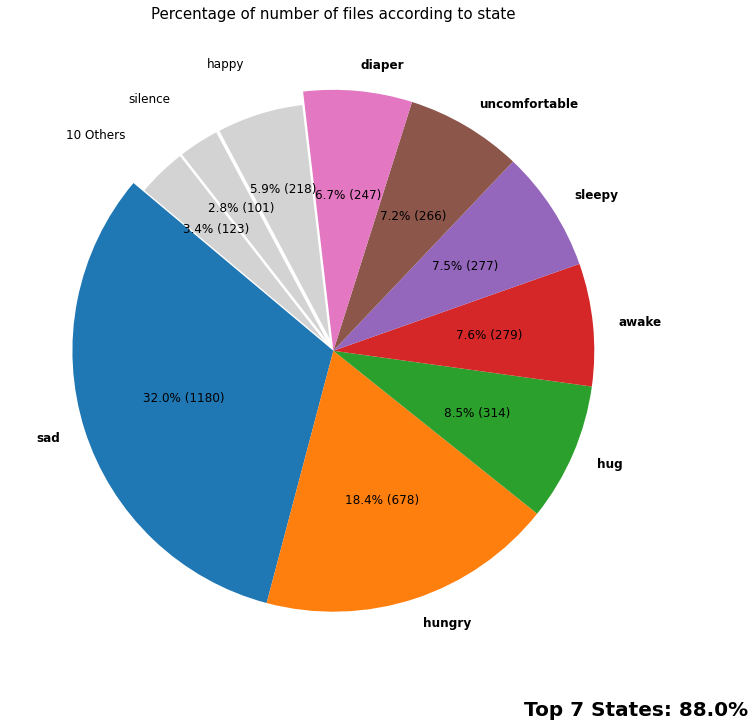

In [5]:
# 전체 데이터의 88%만 사용하며 전체 19개의 state 중 상위 7개만 사용한다.
def plot_state_distribution(csv_path):
    # CSV 파일 읽기
    data = pd.read_csv(csv_path)
    state_counts = data['state'].value_counts()
    colors = sns.color_palette()

    # 강조할 상태 목록 및 설정
    highlight_states = ["sad", "hungry", "hug", "awake", "sleepy", "uncomfortable", "diaper"]
    top_states = state_counts.head(9)
    remaining_count = state_counts[9:].sum()
    top_states['10 Others'] = remaining_count
    highlighted_colors = [colors[i] if state in highlight_states else 'lightgray' for i, state in enumerate(top_states.index)]
    radius_modifiers = [0.9 if state not in highlight_states else 1 for state in top_states.index]
    explode = [0.05 if state not in highlight_states else 0 for state in top_states.index]
    selected_percentage = (top_states[highlight_states].sum() / top_states.sum()) * 100
    
    # 원형 그래프 그리기
    plt.figure(figsize=(17, 12))
    wedges, texts, autotexts = plt.pie(top_states, labels=top_states.index, autopct=lambda p: '{:.1f}% ({:d})'.format(p, int(p/100.*top_states.sum())), startangle=140, colors=highlighted_colors, radius=1, explode=explode, textprops={'fontsize': 12})
    for i, wedge in enumerate(wedges):
        wedge.set_radius(radius_modifiers[i])
    for text in texts:
        if text.get_text() in highlight_states:
            text.set_weight('bold')
    for autotext in autotexts:
        autotext.set_size(12)
    plt.figtext(0.76, 0.08, f'Top 7 States: {selected_percentage:.1f}%', fontsize=20, weight='bold', ha='center')
    plt.title('Percentage of number of files according to state', fontsize=15)
    plt.show()

# 함수 테스트
df = pd.read_csv(csv_path, index_col=0)
plot_state_distribution(csv_path)


In [6]:
from trans_data import get_sample_rate

origin_data_path = os.path.join(main_path, 'origin_data')
file_list = os.listdir(origin_data_path)
error_count = 0

sample_rate_map = {}

for i in tqdm(range(len(file_list))):
    try:
      sample_rate = get_sample_rate(os.path.join(origin_data_path, file_list[i]))
      if sample_rate in list(sample_rate_map.keys()):
          sample_rate_map[sample_rate].append(file_list[i])
      else:
          sample_rate_map[sample_rate] = [file_list[i]]
    except Exception as err:
        error_count += 1
        print(err)

print(f'Error file counts: {error_count}')

100%|██████████| 3688/3688 [00:00<00:00, 5506.54it/s]

Error file counts: 0


Sample rate with 16000 has file counts 2670
file Example: hug_46.wav



/Users/jaewone/ENTER/envs/tf25/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


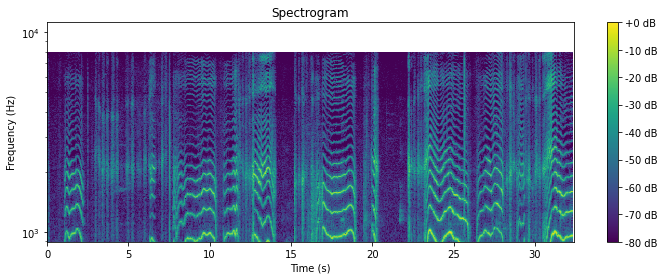

Sample rate with nan has file counts 216
file Example: laugh_1.m4a_83.wav



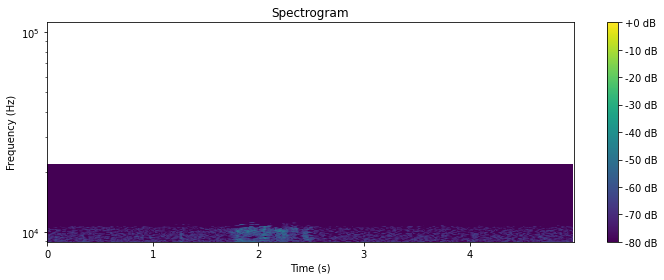

Sample rate with 8000 has file counts 457
file Example: 81724071-bc5e-4e38-8f35-85a691af5721-1430737552979-1.7-m-04-hu.wav



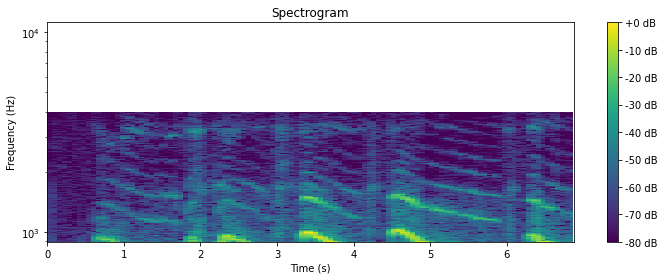

Sample rate with 44100 has file counts 337
file Example: 261.wav



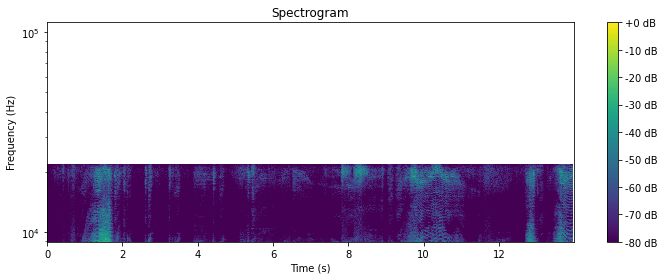

Sample rate with 1600 has file counts 8
file Example: sleepy_15.wav



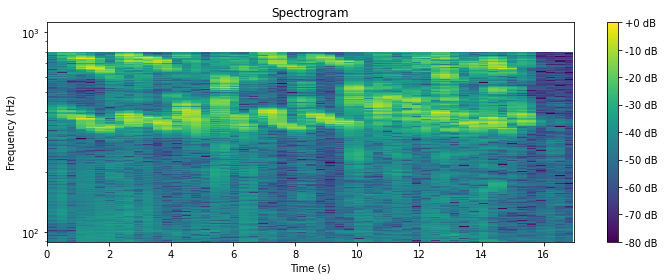

In [7]:
for key in sample_rate_map:
    ex_file = sample_rate_map[key][4]
    print(f'Sample rate with {key} has file counts {len(sample_rate_map[key])}')
    print(f'file Example: {ex_file}\n')
    show_spectrum(os.path.join(origin_data_path, ex_file))

Before and after of 16000 sampling file
File: hug_46.wav


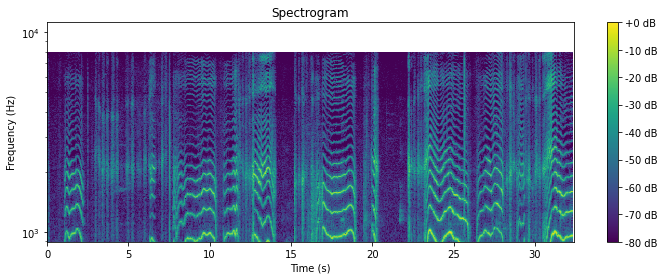

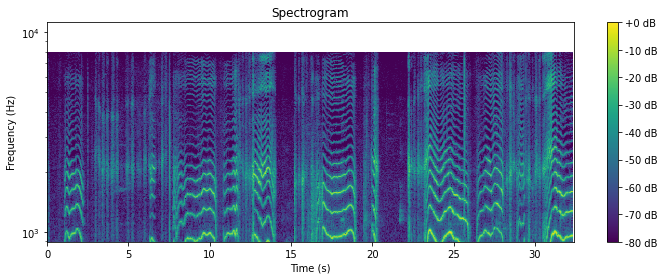

Before and after of nan sampling file
File: laugh_1.m4a_83.wav


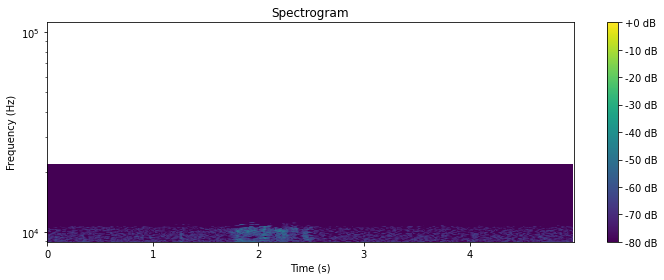

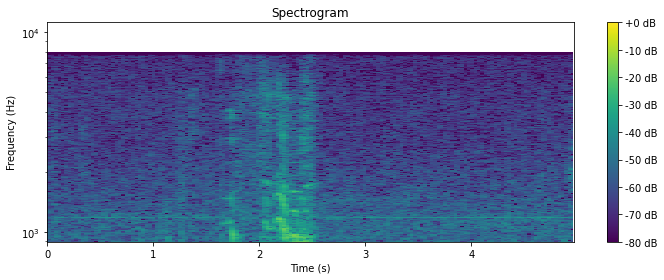

Before and after of 8000 sampling file
File: 81724071-bc5e-4e38-8f35-85a691af5721-1430737552979-1.7-m-04-hu.wav


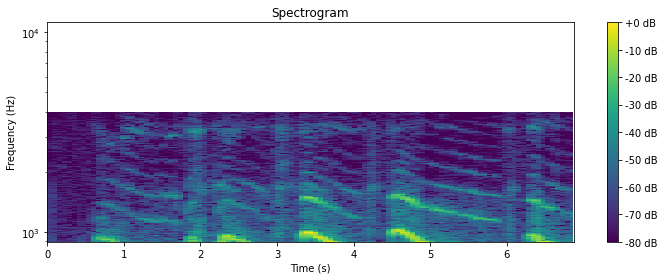

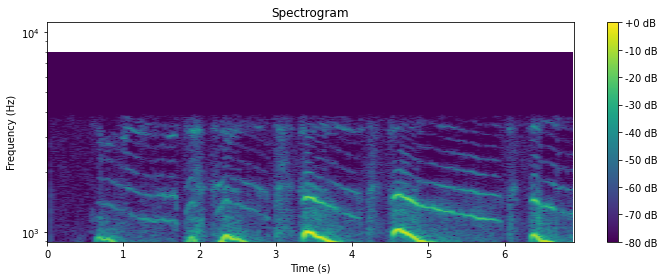

Before and after of 44100 sampling file
File: 261.wav


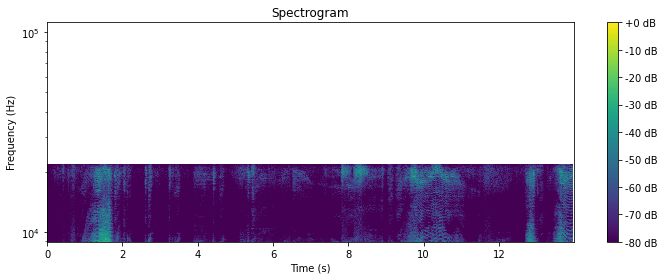

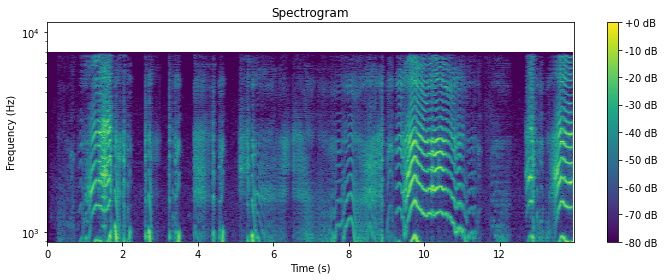

Before and after of 1600 sampling file
File: sleepy_15.wav


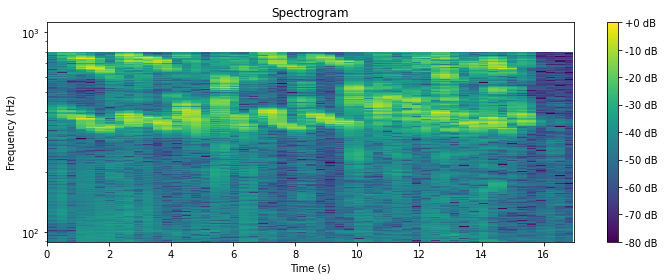

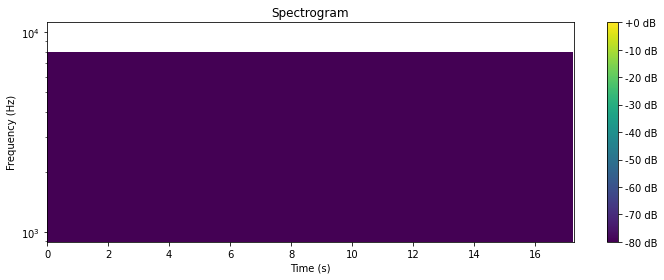

In [8]:
from trans_data import resampling

temp_dir = os.path.join(main_path, '_temp')
create_temp_dir(temp_dir)

for sample_rate in list(sample_rate_map.keys()):
    file = sample_rate_map[sample_rate][4]
    file_path = os.path.join(origin_data_path, file)
    temp_file_path = os.path.join(temp_dir, file)

    print(f'Before and after of {sample_rate} sampling file')
    print(f'File: {file}')
    show_spectrum(file_path)
    resampling([file_path], temp_dir)
    show_spectrum(temp_file_path)

Before and after trimming.
File: laugh_1.m4a_83.wav


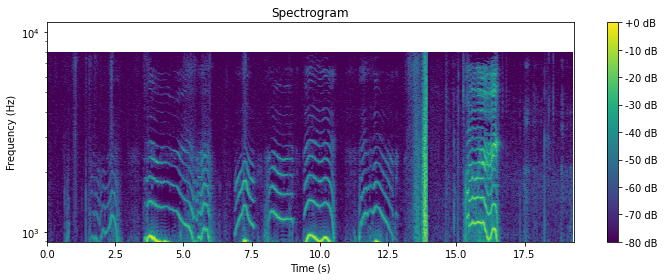

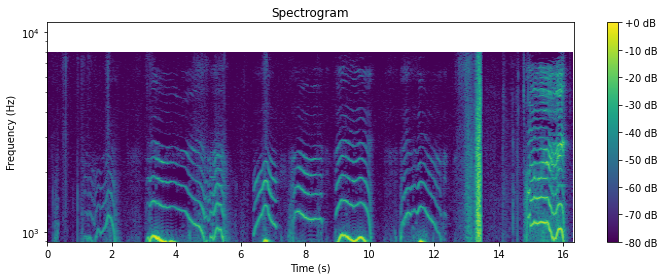

In [17]:
from trans_data import trim_audio

temp_dir = os.path.join(main_path, '_temp')
create_temp_dir(temp_dir)

# TODO trim_audio 시작과 끝 중 가장 극단적으로 보이는거 찾고 표시하기

file = sample_rate_map[sample_rate][4]
file_path = os.path.join(origin_data_path, 'hug_55.wav')
temp_file_path = os.path.join(temp_dir, file)

print(f'Before and after trimming.')
print(f'File: {file}')
show_spectrum(file_path)
trim_audio(file_path, temp_file_path)
show_spectrum(temp_file_path)

remove_path_with_files(temp_dir)